# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])
trainset = datasets.ImageFolder('./Cat_Dog_data/train/', transform=transform)
testset = datasets.ImageFolder('./Cat_Dog_data/test/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

### Visualize data
Top row: Training images; Bottom row: Test images

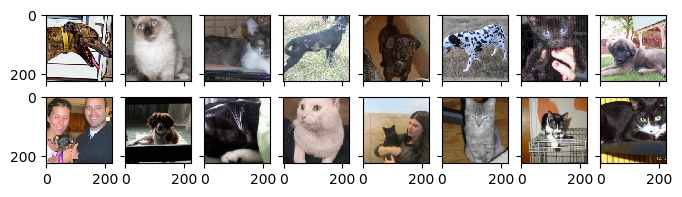

In [3]:
fig, ax = plt.subplots(2,8, figsize=(8,2), dpi=100, sharex=True, sharey=True)
tr_images, _ = next(iter(trainloader))
ts_images, _ = next(iter(testloader))
for i in range(ax.shape[1]):
    image = tr_images[i,:,:,:].numpy().transpose((1,2,0))
    ax[0,i].imshow(image)
    image = ts_images[i,:,:,:].numpy().transpose((1,2,0))
    ax[1,i].imshow(image)
# 
plt.show()

# Model

In [4]:
# Load a pretrained model
model = models.densenet121(pretrained=True)
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Define classifier for our data
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 256)), # densenet121 gives 1024 output features
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(256, 2)), # we have two classes: cat and dog
    ('output', nn.LogSoftmax(dim=1))
]))
# Add defined classifier to the model
model.classifier = classifier

# Training and testing

In [5]:
# Define loss function and optimizer
criterion = nn.NLLLoss() # output was LogSoftmax function
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [6]:
def compute_accurcay(logps, labels):
    ps = torch.exp(logps)
    _, pred_labels = ps.topk(1, dim=1)
    pred_labels = pred_labels.view(*labels.shape)
    equals = (pred_labels == labels).float()
    return float(torch.mean(equals))

In [29]:
def train_nn(model, trainloader, testloader, n_epochs=1):
    # Send model to GPU(s), if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    
    # Initialize losses and accuracies
    tr_losses, ts_losses = [], [] # Train and test losses
    tr_accs, ts_accs = [], [] # Train and test accuracies
    
    for iepoch in range(n_epochs):
        '''Training'''
        tr_loss, tr_acc = 0, 0
        for itr, (images, labels) in enumerate(trainloader):
            # Display progress
            progress_percent = (itr+1)/len(trainloader)*100
            progress_bar = ['.']*int(progress_percent/(len(trainloader)/100))
            sys.stdout.flush()
            sys.stdout.write('\rProgress: {:0.2f} % '.format(progress_percent) \
                             + ''.join(progress_bar) + '>')
                        
            # Send data to device (GPU is available, CPU else)
            images, labels = images.to(device), labels.to(device)
            
            # Model training
            logps = model(images) # Forward pass
            loss = criterion(logps, labels)
            optimizer.zero_grad() # Refresh gradient for backpropagation
            loss.backward() # Backpropagation
            optimizer.step() # Update parameters
            
            # Accumulate loss and accuracy for every batch
            tr_loss += loss.item()
            tr_acc += compute_accurcay(logps, labels)
        # Record losses and accuracies for every epoch
        tr_losses.append(tr_loss/len(trainloader))
        tr_accs.append(tr_acc/len(trainloader))

        '''Testing'''
        ts_loss, ts_acc = 0, 0
        with torch.no_grad():
            model.eval() # Disable dropout (if any) for prediction
            for images, labels in testloader:
                # Send data to GPU or CPU
                images, labels = images.to(device), labels.to(device)
                # Predict class probabilities and loss
                logps = model(images)
                loss = criterion(logps, labels)
                # Accumulate loss and accuracy
                ts_acc += compute_accurcay(logps, labels)
                ts_loss += loss.item()
        # Record losses and accuracies
        ts_losses.append(ts_loss/len(testloader))
        ts_accs.append(ts_acc/len(testloader))
         # Back to train mode by enabling dropout
        model.train()

        print('\nEpoch: {}/{}..'.format(iepoch+1, n_epochs),
              'Training:',
              '(Loss={:0.3f},'.format(tr_losses[iepoch]),
              'Accuracy={:0.3f})..'.format(tr_accs[iepoch]),
              'Test:',
              '(Loss={:.03f},'.format(ts_losses[iepoch]),
              'Accuracy={:0.3f})'.format(ts_accs[iepoch])
             )
    return model

In [30]:
tstart = time.time()
model = train_nn(model, trainloader, testloader)
tend = time.time()
print('Training time: ', tend - tstart)

Progress: 100.00 % ..............>
Epoch: 1/1.. Training: (Loss=0.065, Accuracy=0.975).. Test: (Loss=0.040, Accuracy=0.984)
Training time:  506.4747142791748


# Predict

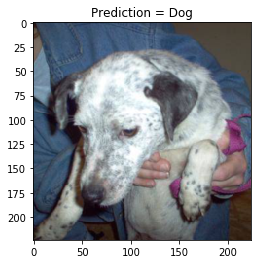

In [82]:
testloader = torch.utils.data.DataLoader(testset, shuffle=True)
# Input image
image, label = next(iter(testloader))

model.to('cpu') # Send model to CPU
model.eval() # Turn model into evaluation mode

# Prediction
with torch.no_grad():    
    p = torch.exp(model.forward(image))
    if p.argmax() == 0:
        title = 'Prediction = Cat'
    else:
        title = 'Prediction = Dog'
# Visualize input image
image = image[0,:,:,:].numpy().transpose((1,2,0))
plt.imshow(image)
plt.title(title)
plt.show()

# Search images in database

In [173]:
def search(search_term):
    if search_term.lower() in 'cats':
        target_argmax = 0
    elif search_term.lower() in 'dogs':
        target_argmax = 1
    else:
        print('No images found. Try for cats or dogs')
        return
    
    testloader = torch.utils.data.DataLoader(testset, shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    ncol = 10
    nrow = 1
    
    fig, ax = plt.subplots(nrow,ncol, figsize=(2*ncol,2), dpi=100)
    
    count = 0
    while count < 10:
        image, _ = next(iter(testloader))
        image = image.to(device)
        with torch.no_grad():
            p = model(image)
            if p.argmax() == target_argmax:
                image = image[0,:,:,:].to('cpu')
                image = image.numpy().transpose((1,2,0))
                ax[count].imshow(image)
                ax[count].axis('off')
                count += 1
    plt.show()
    return

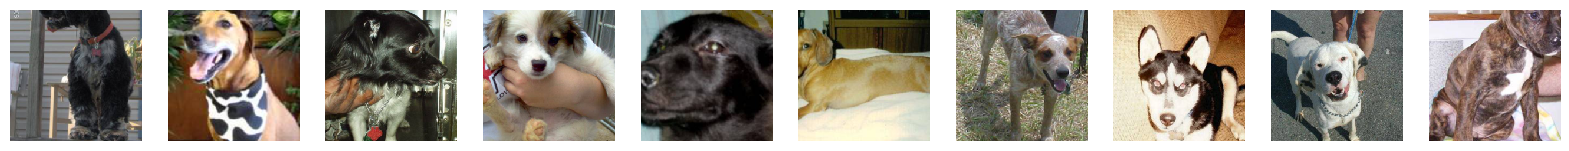

In [184]:
search('dogs')